In [4]:
import csv
import numpy as np
import pandas as pd
from math import factorial

import datetime
from datetime import date
import datetime
import time

import scipy
import os, os.path
from os import listdir
from os.path import isfile, join

import re
# from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb

import sys


# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
import NASA_plot_core as npc

### Set up directories

In [5]:
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/sixth_investig_intersected/"

In [6]:
L5 = pd.read_csv(data_dir + "L5_T1C2L2_Scaled_intGrant_2008-01-01_2012-05-05.csv")
L7 = pd.read_csv(data_dir + "L7_T1C2L2_Scaled_intGrant_2008-01-01_2021-09-23.csv")
L8 = pd.read_csv(data_dir + "L8_T1C2L2_Scaled_intGrant_2008-01-01_2021-10-14.csv")

In [ ]:
VII = "NDVI"
NoVI = "EVI"

In [8]:
L5.drop([NoVI], axis=1, inplace=True)
L5 = L5[L5[VII].notna()]

L7.drop([NoVI], axis=1, inplace=True)
L7 = L7[L7[VII].notna()]

L8.drop([NoVI], axis=1, inplace=True)
L8 = L8[L8[VII].notna()]
L8.head(2)

,ID,NDVI,system_start_time
58302,297619,0.244683,1.364238e+12
58307,297563,0.405628,1.364238e+12


In [11]:
IDs = np.sort(L5.ID.unique())
L578 = pd.concat([L5, L7, L8])
del(L5, L7, L8)

In [12]:
L578 = nc.add_human_start_time_by_system_start_time(L578)

In [13]:
L578.head(2)

,ID,county,NDVI,system_start_time,human_system_start_time
87451,120397,Grant,0.227971,1.204396e+09,2008-03-01
87452,297619,Grant,-0.061698,1.204396e+09,2008-03-01


In [14]:
a_field = L578.loc[L578.ID == IDs[0], ].copy()
a_field.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
a_field.reset_index(drop=True, inplace=True)

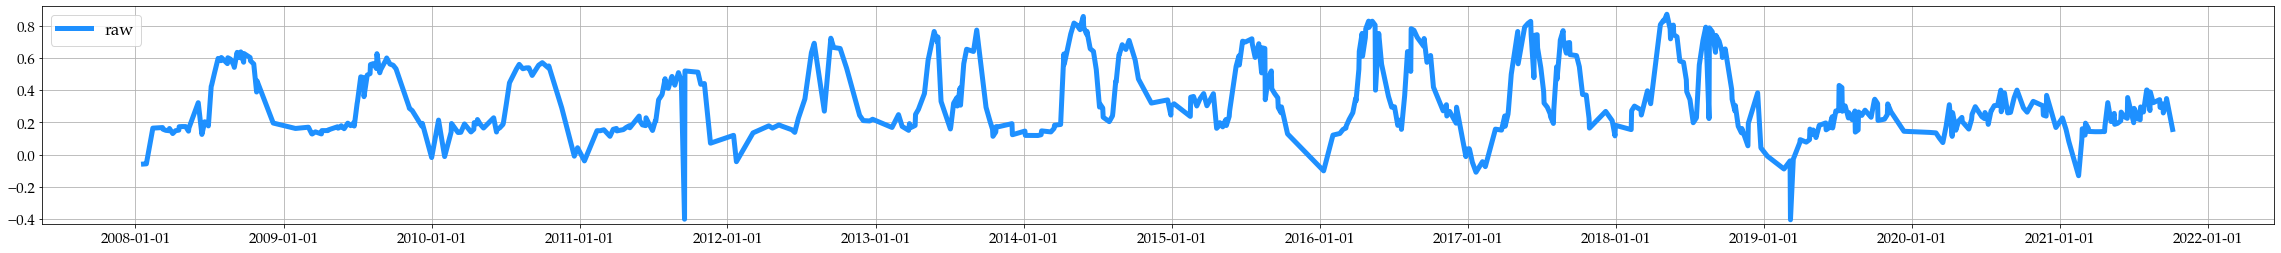

In [41]:
size = 20
title_FontSize = 10
legend_FontSize = 14
tick_FontSize = 18
label_FontSize = 14

params = {'legend.fontsize': 17,
          'figure.figsize': (6, 4),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size * 0.75,
          'ytick.labelsize': size * 0.75,
          'axes.titlepad': 10}

#
#  Once set, you cannot change them, unless restart the notebook
#
plt.rc('font', family = 'Palatino')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update(params)
# pylab.rcParams.update(params)
# plt.rc('text', usetex=True)

fig, ax = plt.subplots(1, 1, figsize=(40, 4),
                        sharex='col', sharey='row',
                        # sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
ax.plot(a_field['human_system_start_time'], a_field['NDVI'], 
        '-', label = "raw", linewidth=5, color='dodgerblue')
ax.xaxis.set_major_locator(mdates.YearLocator(1)) # every year.
ax.legend(loc="upper left");

ax.set_ylim(-0.43, 0.92)


plot_dir = data_dir + "raw_figures/"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
file_name = data_dir + "raw_figures/00_"+ str(IDs[0]) + ".pdf"
plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)

### Remove boundary violations! This does not happen in NDVI! Just sanity check

Moreover, before I did linear interpolation. Here I just set them to 1 and -1. Too many fields and years. This is faster and other people do it as well; suggested by Min in one of the meetings we had for previous project.

In [16]:
a_field.loc[a_field['NDVI'] > 1, "NDVI"]  = 1
a_field.loc[a_field['NDVI'] < -1, "NDVI"] = -1

### Correct big jumps

In [17]:
a_fieldNoJump = nc.correct_big_jumps_1DaySeries(dataTMS_jumpie = a_field, 
                                                give_col = "NDVI", 
                                                maxjump_perDay = 0.018)

a_fieldNoJump.head(2)

,ID,county,NDVI,system_start_time,human_system_start_time
0,91809,Grant,-0.058840,1.200940e+09,2008-01-21
1,91809,Grant,-0.057581,1.201546e+09,2008-01-28


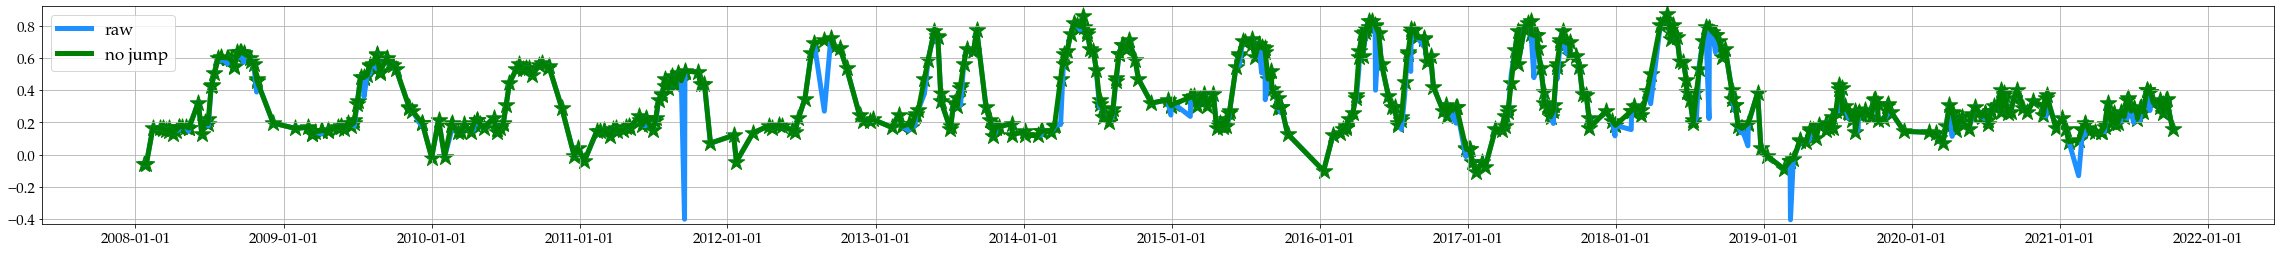

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(40, 4),
                        sharex='col', sharey='row',
                        # sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
ax.plot(a_field['human_system_start_time'], a_field['NDVI'], '-', label = "raw", linewidth=5, color='dodgerblue')
ax.plot(a_field['human_system_start_time'], a_fieldNoJump['NDVI'], '-', label = "no jump", linewidth=5, color='g')
ax.scatter(a_field['human_system_start_time'], a_fieldNoJump['NDVI'], color='g', s=300, marker="*")
ax.xaxis.set_major_locator(mdates.YearLocator(1)) # every year.
ax.legend(loc="upper left");
ax.set_ylim(-0.43, 0.92)

file_name = data_dir + "raw_figures/01_"+ str(IDs[0]) + "_noJump.pdf"
plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)


### Set negatives to 0

In [19]:
a_fieldNoJump_noNeg = a_fieldNoJump.copy()
a_fieldNoJump_noNeg.loc[a_fieldNoJump_noNeg['NDVI'] < 0, "NDVI"] = 0

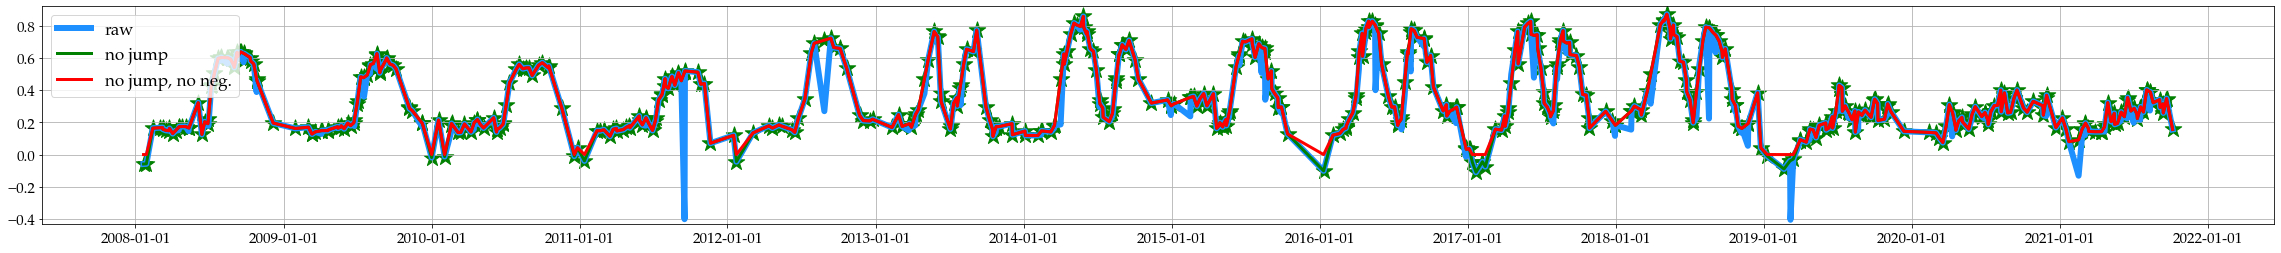

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(40, 4),
                        sharex='col', sharey='row',
                        # sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
ax.plot(a_field['human_system_start_time'], a_field['NDVI'], '-', label = "raw", linewidth=6, color='dodgerblue')

ax.plot(a_field['human_system_start_time'], a_fieldNoJump['NDVI'], '-', label = "no jump", linewidth=3, color='g')
ax.scatter(a_field['human_system_start_time'], a_fieldNoJump['NDVI'], color='g', s=300, marker="*")

ax.plot(a_field['human_system_start_time'], 
        a_fieldNoJump_noNeg['NDVI'], 
        '-', label = "no jump, no neg.", linewidth=3, color='r')
ax.xaxis.set_major_locator(mdates.YearLocator(1)) # every year.
ax.set_ylim(-0.43, 0.92)
ax.legend(loc="upper left");

file_name = data_dir + "raw_figures/02_"+ str(IDs[0]) + "_noJump_noNeg.pdf"
plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)


### Regularize (10-day composite) and do SG

In [21]:
a_fieldNoJump_noNeg['dataset'] = "L578"
step_size = 10

a_fieldNoJump_noNeg_Reg = nc.regularize_a_field(a_df = a_fieldNoJump_noNeg, 
                                                V_idks = 'NDVI', 
                                                interval_size = step_size)
a_fieldNoJump_noNeg_Reg = nc.fill_theGap_linearLine(a_fieldNoJump_noNeg_Reg, V_idx='NDVI')

In [22]:
SG = scipy.signal.savgol_filter(a_fieldNoJump_noNeg_Reg['NDVI'].values, window_length=7, polyorder=3)

# SG might violate the boundaries. clip them:
SG[SG > 1 ] = 1
SG[SG < -1 ] = -1

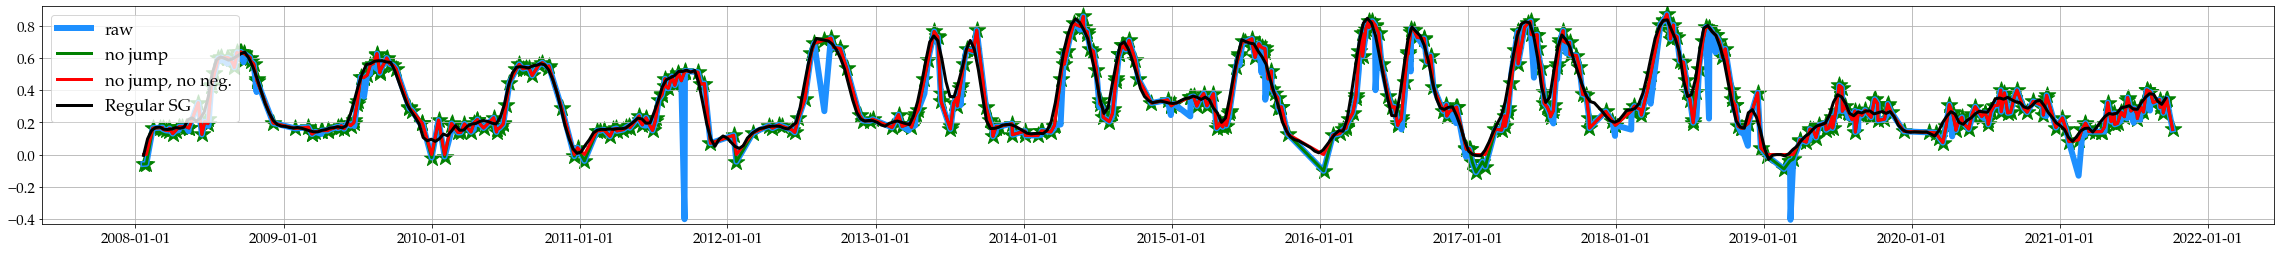

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(40, 4),
                        sharex='col', sharey='row',
                        # sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);

ax.plot(a_field['human_system_start_time'], a_field['NDVI'], '-', label = "raw", linewidth=6, color='dodgerblue')
ax.plot(a_field['human_system_start_time'], a_fieldNoJump['NDVI'], '-', label = "no jump", linewidth=3, color='g')
ax.scatter(a_field['human_system_start_time'], a_fieldNoJump['NDVI'], color='g', s=300, marker="*")

ax.plot(a_field['human_system_start_time'], 
        a_fieldNoJump_noNeg['NDVI'], 
        '-', label = "no jump, no neg.", linewidth=3, color='r')

ax.plot(a_fieldNoJump_noNeg_Reg['human_system_start_time'], 
        SG, 
        '-', label = "Regular SG", linewidth=3, color='k')

ax.xaxis.set_major_locator(mdates.YearLocator(1)) # every year.
ax.set_ylim(-0.43, 0.92)
ax.legend(loc="upper left");

file_name = data_dir + "raw_figures/03_"+ str(IDs[0]) + "_noJump_noNeg_" + str(step_size) + "regul.pdf"
plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)


In [24]:
a_fieldNoJump_noNeg_Reg["NDVI"] = SG